## Question 1 ##
### Image enhancement using log transformation and histogram equalization ###
I used two methods for image enhancement in this question.
As one of the goals was to brighten the pixels,
 the first method I came up with was log transformation.
 The reason why I didn't go with linear transformations was that I was
 looking to have more increase in the intensity of darker pixels than the
 brighter ones. Also based on the 14th slide of the 4th lecture, we can see that this happens for
$\alpha > 0$ in log transformations.
<br>
Below is the function for this transformation:

In [8]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

def logTransformation(image, alpha):
    c = 255 / np.log(1 + alpha * 255)
    result = (c * (np.log(1 + alpha * image))).astype('uint8')
    return result

Which is simply the calculation of $\frac{255 \times log(1 + \alpha x)}{log(1 + 255 \alpha)}$.
Also, I turned it in to an array of type unit8 in case of an overflow.
<br>
I tested this function for $\alpha = 0.01, 0.05, 0.1, 0.15, 0.2, 0.4$

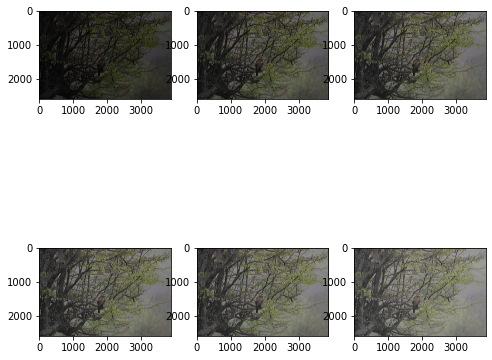

In [9]:
fig = plt.figure(figsize=(8, 8))
alpha = [0.01, 0.05, 0.1, 0.15, 0.2, 0.4]
for i in range(0, 6):
    fig.add_subplot(2, 3, i+1)
    plt.imshow(logTransformation(cv2.cvtColor(cv2.imread("Enhance1.JPG"), cv2.COLOR_BGR2RGB), alpha[i]))
plt.show()

It seems that $\alpha = 0.15$ produced convenient result.

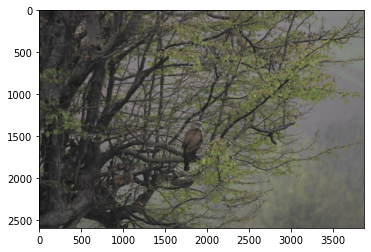

In [10]:
plt.imshow(logTransformation(cv2.cvtColor(cv2.imread("Enhance1.JPG"), cv2.COLOR_BGR2RGB), 0.15))

Next step is to increase the contrast of the image. I did this by equalizing the histogram of it.
I split the image in 3 channels (B, G, R) and treated them individually at first and then merged them in to a single image.
<br>
First, I started by computing the histogram of the channel using np.histogram and then calculated the cumulative sum of it.
I used the formulate stated in the book. We have $L - 1  = 256 - 1 = 255$, also $M$ and $N$ are
. I also made the arrays have uint8 type in case of an overflow.

In [11]:
import numpy as np
import cv2


def equalizeHistogram(image):
    b, g, r = cv2.split(image)
    height, width, channels = image.shape

    B_hist, _ = np.histogram(image[:, :, 0], bins=256, range=[0, 256])
    G_hist, _ = np.histogram(image[:, :, 1], bins=256, range=[0, 256])
    R_hist, _ = np.histogram(image[:, :, 2], bins=256, range=[0, 256])

    B_cumSum = (np.cumsum(B_hist) * 255 / (height * width)).astype('uint8')
    G_cumSum = (np.cumsum(G_hist) * 255 / (height * width)).astype('uint8')
    R_cumSum = (np.cumsum(R_hist) * 255 / (height * width)).astype('uint8')

    return cv2.merge((B_cumSum[b], G_cumSum[g], R_cumSum[r]))


I tested this on the image and got the result below:

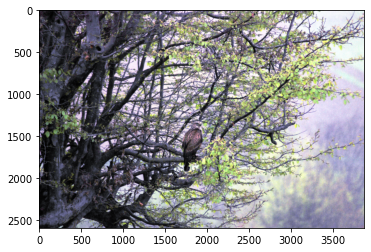

In [12]:
plt.imshow(equalizeHistogram(cv2.cvtColor(cv2.imread("Enhance1.JPG"), cv2.COLOR_BGR2RGB)))



Also, by combining histogram equalization method and log transformation with $\alpha = 0.15$, the following result in obtained:

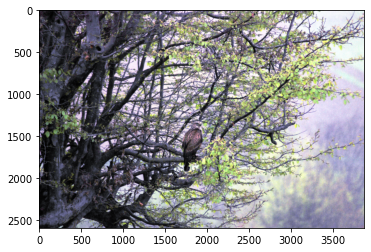

In [13]:
img2 = logTransformation(cv2.imread("Enhance1.JPG"), 0.15)
plt.imshow(equalizeHistogram(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)))



## Question 2 ##
### Image enhancement ###
This question requires somehow the same enhancement as the previous question. So I used log transformation for
brightening the darker pixels and the applied histogram equalization to it.
<br>
Again, I tested this function for $\alpha = 0.01, 0.05, 0.1, 0.15, 0.2, 0.4$


In [1]:
fig = plt.figure(figsize=(8, 8))
alpha = [0.01, 0.05, 0.1, 0.15, 0.2, 0.4]
for i in range(0, 6):
    fig.add_subplot(2, 3, i+1)
    plt.imshow(logTransformation(cv2.cvtColor(cv2.imread("Enhance2.JPG"), cv2.COLOR_BGR2RGB), alpha[i]))
plt.show()



NameError: name 'plt' is not defined

I decided to go with $\alpha = 0.05$ and then by equalizing its histogram, I got:

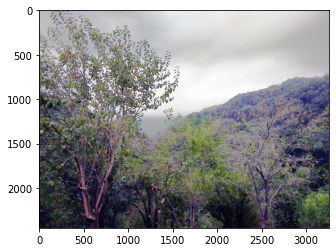

In [15]:
img2 = logTransformation(cv2.imread("Enhance2.JPG"), 0.05)
plt.imshow(equalizeHistogram(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)))


However, It can be seen that the equalization changed it drastically, resulting in different colors.
Another approach is applying histogram equalization only on the Hue channel:

In [ ]:
def equalizeOnH(image):
    height, width, channels = image.shape
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = hsv[:, :, 0], hsv[:, :, 1], hsv[:, :, 2]

    hist, _ = np.histogram(h, bins=180, range=[0, 180])
    cumsum = (np.cumsum(hist) * 255 / (height * width)).astype('uint8')

    img = np.dstack((cumsum[h], s, v))
    return cv2.cvtColor(img, cv2.COLOR_HSV2BGR)

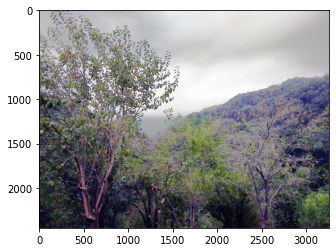

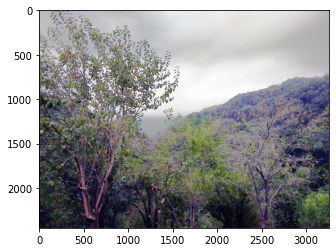

In [17]:
img2 = logTransformation(cv2.imread("Enhance2.JPG"), 0.05)
plt.imshow(equalizeHistogram(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)))

It again changed drastically, so I ended up using only log transformation.

## Question 3 ##
### Images of the Russian Empire: Colorizing the Prokudin photo collection.   (recreate a colored image of 3 gray scale images corresponding to each channel) ###
The process I used for this question is as follows:
<ol>
    <li>Seperate the channels</li>
    <li>Use image pyramid by creating images in different sizes</li>
    <li>For each one, aligne the blue and the red one on the green channel(fixed one) using ssd metric and searching over a (-7, 7) window</li>
    <li>Find the best offset and move channels with it</li>
    <li>Auto crop the edeges using edge detection</li>
    <li>Save it in a more compressed format (jpg)</li>
</ol>

### separating channels ###
I went with a simple method which was just cutting image vertically in to three equal parts: channels B, G, and R.
<br>
 At first, I wanted to crop the white and black margins. I tried two methods 1.cutting %5 from the edges. 2.Cropping the white and then black space around it with four while loops to detect the edges.
   Although these methods worked, I noticed that I still need to auto crop the final result and that they didn't yield in different results from the first simple method.
   ( so I commented them out)

In [1]:
def separateChannels(img):
    height = int(img.shape[0] / 3)

    B = img[:height]
    G = img[height:2 * height]
    R = img[2 * height:3 * height]

    return np.dstack([B, G, R])



### Aligning images ###
The naive method is to shift one color channel on top of another over a (-7, 7) window and compute the difference between them.
The metric used is the Sum of Squared Differences (SSD) and the goal was to find the best displacement having the minimum amount for ssd.

In [ ]:
def align(channel1, channel2):
    opt_offset = np.zeros(2, dtype=np.int16)
    minValue = None
    for x in range(-7, 7):
        for y in range(-7, 7):
            s, m = shift(channel1, channel2, (x, y))
            ssd = calculateSSD(np.asarray(s, dtype="int16"), np.asarray(m, dtype="int16"))
            if minValue is None or ssd < minValue:
                minValue = ssd
                opt_offset[0], opt_offset[1] = x, y
    return opt_offset

In [ ]:
def calculateSSD(shifted1, shifted2):
    return np.average((shifted1 - shifted2) ** 2)

In [ ]:
def shift(ch1, ch2, offset):
    x, y = offset
    height, width = ch2.shape
    return ch1[max(y, 0): height + min(y, 0), max(x, 0): width + min(x, 0)], \
           ch2[-min(y, 0): height - max(y, 0), -min(x, 0): width - max(x, 0)]

In order to shift the channels for the corresponding x and y, one way was to use np.roll(b, (x, y), axis=(1, 0)), however this doesn't change the size of an image, instead rolls the indices to the end (beginning) of it.
I realised that cropping the images in a way that they fit together had better results.
<br>
In the code above, I just simplified this for channels c1 and c2:
<br>
 x $\ge$ 0, y $\ge$ 0 $\rightarrow$ c1[y:, x:], c2[:height-y, :width-x] <br>
 x $\ge$ 0, y $\le$ 0 $\rightarrow$ c1[:height+y, x:], c2[-y:, :width-x] <br>
 x $\le$ 0, y $\ge$ 0 $\rightarrow$ c1[y:, :width+x], c2[:height-y, -x:] <br>
 x $\le$ 0, y $\le$ 0 $\rightarrow$ c1[:height+y, :width+x], c2[-y:, -x:] <br>


### Image Pyramid ###
Although this alignment approach works fine with low resolution images, It needs a larger interval of search window and hence more time in higher resolution images.
So, I used image pyramid method. An image pyramid is a collection of an image at different resolutions. It is simply down sampling the image by some factor ( here the powers of 2) and finding the best offset, then go a level up, shift the images by double the amount of that offset; so we know that we are searching in an optimal interval. Continuing by updating the estimate until we reach to the actual image size we are interested in.
 <br>
I started with calculating the depth needed and if we set the minimum width to be $w = 100$ pixels, the depth would be $d = log_2(width / 100)$.
Then by starting from the lowest level, I used cv2.resize to lower the resolution (by reducing it to $\frac{1}{2^{depth}})$ and retrieved the best offset with estimating the alignment.
Next, I calculated the offset for the next level ($\times 2 ^{depth}$) and shift the images to fit and repeat the process.

In [ ]:
def colorize(img):
    img = separateChannels(img)
    b, g, r = cv2.split(img)
    height, width, _ = img.shape
    # we fix the channel g and align channels b and r with it:
    offset1, offset2 = np.zeros(2, dtype=np.int16), np.zeros(2, dtype=np.int16)
    depth = int(np.log2(width / 100))
    # image pyramid here:
    for i in range(depth, -1, -1):
        offset1 += computeOffset(g, b, offset1, i)
        offset2 += computeOffset(g, r, offset2, i)

        xb, yb = offset1
        xr, yr = offset2
        b = np.roll(b, (xb, yb), axis=(1, 0))
        r = np.roll(r, (xr, yr), axis=(1, 0))
        print('the offset for green and blue images: '+ str(offset1)+ ' the offset for green and red images: ' + str(offset2) + ' depth: ' + str(i))

        hfrom, hto = max(yb, yr, 0), min(height, height + yb, height + yr)
        wfrom, wto = max(xb, xr, 0), min(width, width + xb, width + xr)

        Image = np.dstack([layer[hfrom:hto, wfrom:wto] for layer in [b, g, r]])
        cv2.imshow(str(i), Image)

In [ ]:
def computeOffset(ch1, ch2, offset, depth):
    ch1, ch2 = shift(ch1, ch2, offset)
    ch1, ch2 = cv2.resize(ch1, (0, 0), fx=0.5 ** depth, fy=0.5 ** depth), cv2.resize(ch2, (0, 0), fx=0.5 ** depth, fy=0.5 ** depth)
    offset = (2 ** i) * align(ch1, ch2)
    return offset

### Border Cropping ###
I used the following function to detect where the hue values of a row or a column are close to each other. then i decided to compute the standard deviation and set a limit to it.

In [ ]:
def cropEdges(img):
    height, width, _ = img.shape
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h = hsv[:, :, 0]
    edge1, edge2, edge3, edge4 = 0, 0,0, 0
    for i in range(int(height / 8)):
        if (np.std(h[i, :])) < 30:
            edge1 = i
        if (np.std(h[height - i - 1, :])) < 30:
            edge2 = height - i - 1
    img = img[edge1: edge2, :, :]

    for i in range(int(width / 8)):
        if (np.std(h[:, i])) < 30:
            edge3 = i
        if (np.std(h[:, width - i - 1])) < 30:
            edge4 = width - i - 1
    img = img[:, edge3: edge4, :]
    return img

## Question 4 ##
### Changing the color of a specific part of an image and blurring the rest###
For changing the flower's color from pink to yellow, I wanted to detect the pink colors, so I converted RGB to HSV.
Then, I look for the H values in flowers. It turned out that they fall in to an interval of 140 <= h <= 165.
Next, I used a mask and a logical and to detect the area and Then applied it to the h channel of the image and set its pixels to have a value of 25, which equivalent to yellow color.

In [ ]:
path = "../images/Flowers.jpg"
img = cv2.imread(path)
r, g, b = cv2.split(img)

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

h, s, v = hsv[:, :, 0], hsv[:, :, 1], hsv[:, :, 2]

mask1= np.logical_and(h <= 178, h >= 138, s>=30)
# mask2 = np.logical_and(h >= 165, h <= 175)
# mask = np.logical_or(mask1, mask2)
hsv[mask1, 0] = 25
yellowImage = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

For blurring the image, I used cv2.filter2D and as the goal was to keep the flowers un touched, I again used a mask to cover the h interval in which the flowers are.
Eventually, I applied the given mask to all the channels and used np.where to replace the blurred pixel for all the other parts.

In [ ]:
kernel = np.ones((22, 22), np.float32) / 22 ** 2
blurredImage = cv2.filter2D(img, -1, kernel)
blurHsv = cv2.cvtColor(blurredImage, cv2.COLOR_BGR2HSV)

h, s, v = hsv[:, :, 0], hsv[:, :, 1], hsv[:, :, 2]

mask1 = np.logical_and(h <= 26, h >= 24)
# mask2 = np.logical_and(h >= 165, h <= 175)
# mask3 = np.logical_or(mask1, mask2)
mask = np.dstack((mask1, mask1, mask1))

result = np.where(mask, hsv, blurHsv)
result = cv2.cvtColor(result, cv2.COLOR_HSV2BGR)

cv2.imwrite("res06.jpg", result)
cv2.imshow('image', result)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Question 5 ##
### Implementing image blurring in 3 different ways ###
I used the inbuilt function cv2.filter2D in the first method.

In [ ]:
import time


def cv2Filter(k, img):
    n = 2 * k + 1
    height, width, _ = img.shape
    t0 = time.time()
    kernel = np.ones((n, n), np.float32) / n ** 2
    img = cv2.filter2D(img, -1, kernel)
    img = img[k: height - k, k: width - k, :]
    t1 = time.time()
    cv2.imwrite("res07.jpg", img)
    return (t1 - t0), img

For the second approach, I used two for loops for each channel and applied convolution based on the cross-correlation formula(lecture 5)

In [ ]:
def dumbFilter(k, img):
    n = 2 * k + 1
    height, width, channels = img.shape
    t0 = time.time()
    result = np.zeros((height, width, 3))
    print(result.shape)
    for channel in range(3):
        for i in range(k, height - k - 1):
            for j in range(k, width - k - 1):
                result[i, j, channel] = np.sum(img[i - k:i + k + 1, j - k:j + k + 1, channel]) / n ** 2

    t1 = time.time()
    result = result[k: height - k, k: width - k, :]
    print(result.shape)
    cv2.imwrite("res08.jpg", result)
    return (t1 - t0), result

Furthermore, in the third method, I calculated the matrix for the (i,j)th cell in the kernel in which this cell is applied to the image pixels.
It can be seen that img[i:height - (2 * k - i), j:width - (2 * k - j)] is the corresponding matrix.
<br> Hence, it is enough to sum all these arrays up and multiply it with $\frac{1}{n^2}$

In [ ]:
def improvedFilter(k, img):
    n = 2 * k + 1
    height, width, _ = img.shape
    t0 = time.time()
    result = []
    for channel in range(3):
        sumArr = np.zeros((height - 2 * k, width - 2 * k))
        for i in range(n):
            for j in range(n):
                sumArr += img[i:height - (2 * k - i), j:width - (2 * k - j), 2 - channel] / n ** 2
        sumArr = sumArr.astype(np.uint8)
        result.insert(0, sumArr)

    blurredImage = np.dstack(result)
    t1 = time.time()
    cv2.imwrite("res09.jpg", blurredImage)
    return (t1 - t0), blurredImage

They all had the same image result. However, the timing was different:
<br>
cv2 time: 0.046495914459228516dumb,  filter time: 203.70104002952576,  improved filter time: 1.3221487998962402

## Question 6 ##
### Histogram matching of two images ###
Let's assume we have two pictures named img1 and img2. We want to make img1's histogram similar to img2's.
Fist, I split the image in three channels(b, g, r), match the histograms separately and then merged the channels. For channel x, I calculated the pdf and then the normalized cdf of img1[:,:,x] and img2[:,:,x].

In [ ]:
def matchHistograms(path1, path2):
    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)

    matchedBlueChannel = matchChannels(getCdf(img1, 0), getCdf(img2, 0), img1[:, :, 0])
    matchedGreenChannel = matchChannels(getCdf(img1, 1), getCdf(img2, 1), img1[:, :, 1])
    matchedRedChannel = matchChannels(getCdf(img1, 2), getCdf(img2, 2), img1[:, :, 2])

    result = cv2.merge([matchedBlueChannel, matchedGreenChannel, matchedRedChannel])
    result = cv2.convertScaleAbs(result)

    resPdf, resBin = np.histogram(result, bins=256, range=[0, 256])
    img1Pdf, img1Bin = np.histogram(img2, bins=256, range=[0, 256])

    plt.plot(resBin[0:-1], resPdf, color="blue")
    plt.plot(img1Bin[0:-1], img1Pdf, color="green")
    plt.plot(resBin[0:-1], np.cumsum(resPdf), color="yellow")
    plt.plot(img1Bin[0:-1], np.cumsum(img1Pdf), color="red")
    plt.show()

    cv2.imwrite("res11.jpg", result)
    cv2.imshow('image', result)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [ ]:
def getCdf(img, channel):
    hist, _ = np.histogram(img[:, :, channel], bins=256, range=[0, 256])
    cdf = np.cumsum(hist)
    return cdf / float(cdf.max())

Next, for each index v1 in (0, 255) for img1's cdf, I started looking for the smallest index v2 in cf2 in which
cdf1[v1] <= cdf2[v2], and then changed the intensity of all pixels (in img1) with intensity v1 to v2.
In the following code in did this by making a new matrix result.

In [3]:
def matchChannels(cdf1, cdf2, channel1):
    lut = np.zeros(256)  # lookuptable = lut
    vr = 0
    for v1 in range(256):
        for v2 in range(256):
            if cdf2[v2] >= cdf1[v1]:
                vr = v2
                break
        lut[v1] = vr

    return changePixels(channel1, lut)


def changePixels(ch, lut):
    result = np.zeros(ch.shape)
    for i in range(256):
        result[ch == i] = lut[i]
    return result

Then, I plot their pdf and cdf with the pdf of result and img2 having blue and green colors and the cdf of result and img2 having
yellow and red colors.



